In [60]:
import pandas as pd
import xgboost
import numpy as np
import torch
from shap import GradientExplainer
import matplotlib.pyplot as plt

In [2]:
wine_df = pd.read_csv('winequality.csv')

In [3]:
wine_df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


### Data Exploration

#### Missing Values


In [4]:
n=0
for col in wine_df.columns:
    missing = wine_df[col].isnull().sum()
    
    if missing > 0:
        print(f' {col} is missing {missing} values')
        n=1
        
if n==0:
    print('No missing values!')

No missing values!


#### Distributions

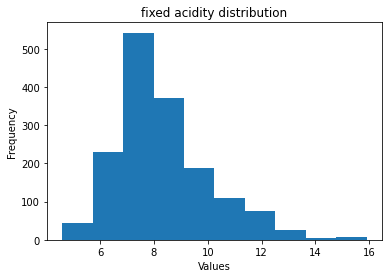

In [5]:
column = 0
wine_df[wine_df.columns[column]].plot.hist()
plt.title(f'{wine_df.columns[column]} distribution')
_=plt.xlabel('Values')

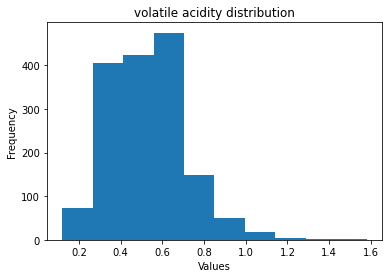

In [6]:
column = 1
wine_df[wine_df.columns[column]].plot.hist()
plt.title(f'{wine_df.columns[column]} distribution')
_=plt.xlabel('Values')

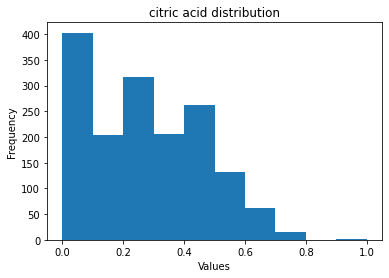

In [7]:
column = 2
wine_df[wine_df.columns[column]].plot.hist()
plt.title(f'{wine_df.columns[column]} distribution')
_=plt.xlabel('Values')

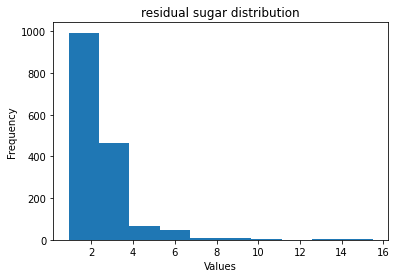

In [8]:
column = 3
wine_df[wine_df.columns[column]].plot.hist()
plt.title(f'{wine_df.columns[column]} distribution')
_=plt.xlabel('Values')

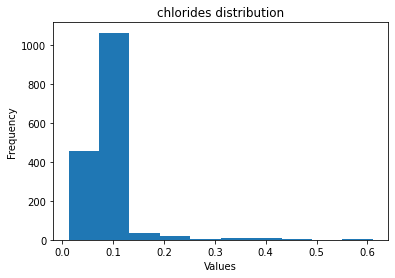

In [9]:
column = 4
wine_df[wine_df.columns[column]].plot.hist()
plt.title(f'{wine_df.columns[column]} distribution')
_=plt.xlabel('Values')

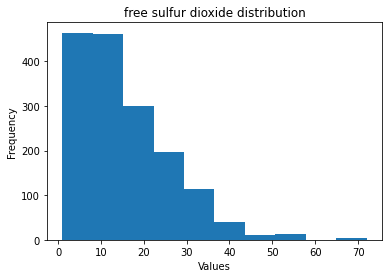

In [10]:
column = 5
wine_df[wine_df.columns[column]].plot.hist()
plt.title(f'{wine_df.columns[column]} distribution')
_=plt.xlabel('Values')

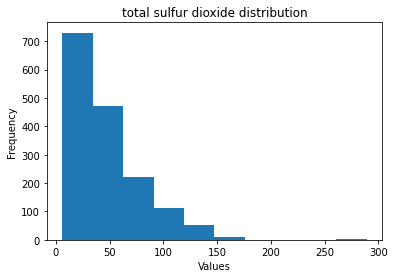

In [11]:
column = 6
wine_df[wine_df.columns[column]].plot.hist()
plt.title(f'{wine_df.columns[column]} distribution')
_=plt.xlabel('Values')

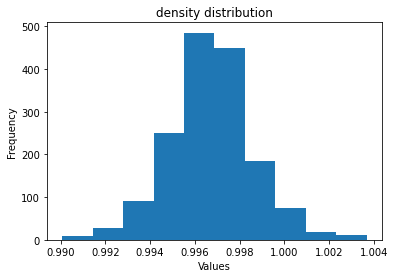

In [12]:
column = 7
wine_df[wine_df.columns[column]].plot.hist()
plt.title(f'{wine_df.columns[column]} distribution')
_=plt.xlabel('Values')

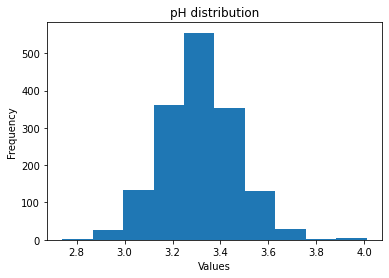

In [13]:
column = 8
wine_df[wine_df.columns[column]].plot.hist()
plt.title(f'{wine_df.columns[column]} distribution')
_=plt.xlabel('Values')

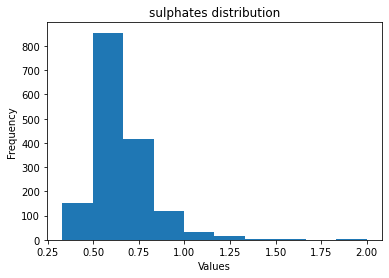

In [14]:
column = 9
wine_df[wine_df.columns[column]].plot.hist()
plt.title(f'{wine_df.columns[column]} distribution')
_=plt.xlabel('Values')

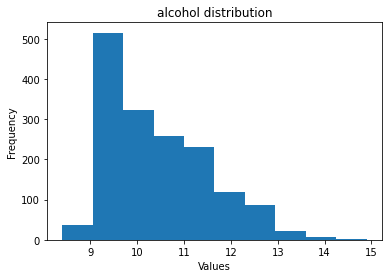

In [15]:
column = 10
wine_df[wine_df.columns[column]].plot.hist()
plt.title(f'{wine_df.columns[column]} distribution')
_=plt.xlabel('Values')

6

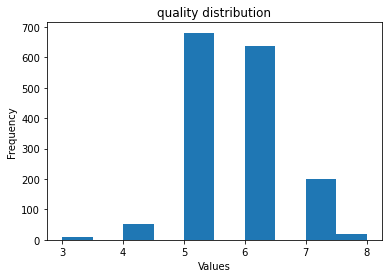

In [30]:
column = 11
wine_df[wine_df.columns[column]].plot.hist()
plt.title(f'{wine_df.columns[column]} distribution')
_=plt.xlabel('Values')

wine_df[wine_df.columns[column]].nunique()

## Prepare the Dataset

In [34]:
def min_max_normalize_df(dataframe, exclude_fields=[]):
    '''
    This function takes in a dataframe and normalizes columns between -1 and 1 based on their min/max values.
    
    Inputs -
    dataframe: the dataframe to be transformed
    exclude_fields: list of columns that should not be normalized
    
    Returns -
    new_df: copy of input dataframe with normalized columns (except for columns in exclude_fields)
    '''
    #Copy input df
    new_df = dataframe.copy()
    
    #Get list of usable columns    
    included_columns = [x for x in new_df.columns if x not in exclude_fields]
    
    #Iterate through included columns and normalize the fields column-wise
    for col in included_columns:
        minimum, maximum = dataframe[col].min(), dataframe[col].max()
        new_df[col] = new_df[col].apply(lambda x: ((x-minimum)/(maximum-minimum)) * 2 - 1)
        
    return new_df

In [35]:
wine_df = min_max_normalize_df(wine_df, ['quality'])

In [36]:
#Split into training, validation, and testing dataframes
intermediate_df = wine_df.sample(frac=0.8)
train_df = intermediate_df.sample(frac=0.6)
val_df = intermediate_df[~intermediate_df.isin(train_df)].dropna()
test_df = wine_df[~wine_df.isin(intermediate_df)].dropna()

#Little helper function for converting to tensors
def to_tensor(df):
    df = torch.tensor(df.values.astype(np.float32))
    return df

train_x = to_tensor(train_df.drop('quality', axis=1))
train_y = to_tensor(train_df['quality'])

val_x = to_tensor(val_df.drop('quality', axis=1))
val_y = to_tensor(val_df['quality'])

test_x = to_tensor(test_df.drop('quality', axis=1))
test_y = to_tensor(test_df['quality'])

In [37]:
batch_size = 1

train_tensor = torch.utils.data.TensorDataset(train_x, train_y) 
train_loader = torch.utils.data.DataLoader(dataset = train_tensor, batch_size = batch_size, shuffle = True)

val_tensor = torch.utils.data.TensorDataset(val_x, val_y) 
val_loader = torch.utils.data.DataLoader(dataset = val_tensor, batch_size = batch_size, shuffle = True)

test_tensor = torch.utils.data.TensorDataset(test_x, test_y) 
test_loader = torch.utils.data.DataLoader(dataset = test_tensor, batch_size = 1, shuffle = True)

In [43]:
import torch.nn as nn
import torch.nn.functional as F

class DNN(nn.Module):
    def __init__(self, dense_dim):
        super(DNN, self).__init__()
        
        #Input Layer
        self.fcn1 = nn.Linear(11, dense_dim)
        
        #Hidden Layers
        self.fcn2 = nn.Linear(dense_dim, 2*dense_dim)
        self.fcn4 = nn.Linear(2*dense_dim, dense_dim)
        
        #Output Layer
        self.fcn5 = nn.Linear(dense_dim, 1)
        
        self.drop = nn.Dropout(0.2)
                
    def forward(self, x):
        x = (F.relu(self.fcn1(x)))
        
        x = self.drop(F.relu(self.fcn2(x)))
        #x = self.drop(F.relu(self.fcn3(x)))
        x = (F.relu(self.fcn4(x)))
        
        x = self.fcn5(x)
        
        x = x.view(-1)
        
        return x

In [48]:
import torch.optim as optim

def train(epochs, model):
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    model.train()
    batch_loss = []
    other_batch_loss = []
    
    train_history = []
    val_history = []
    
    prev_loss = np.inf
    
    for epoch in range(1, epochs+1):
        for batch, (x,y) in enumerate(train_loader, 0):
            model.train()
            model.zero_grad()
            
            prediction = model(x)
            
            loss = criterion(prediction, y)
            loss.backward()
            optimizer.step()
            
            batch_loss.append(loss.data.numpy())
        

        for batch, (x,y) in enumerate(val_loader, 0):
            with torch.no_grad():
                model.eval()

                other_prediction = model(x)

                other_loss = criterion(other_prediction, y)

                other_batch_loss.append(other_loss.data.numpy())

        new_loss = round(float(np.average(batch_loss)), 5)
        val_loss = float(np.average(other_batch_loss))
        
        train_history.append(new_loss)
        val_history.append(val_loss)
        
        if epoch%10==0:
            print('Epoch: ' + str(epoch))
            print(f'Loss: {prev_loss} ----> {new_loss}')
        
        prev_loss = new_loss
    
    fig, axe = plt.subplots()
    plt.plot(train_history, label='Training')
    plt.plot(val_history, label='Validation')
    plt.legend()
    
    return model
            

Epoch: 10
Loss: 0.74182 ----> 0.72064
Epoch: 20
Loss: 0.6074 ----> 0.60056
Epoch: 30
Loss: 0.556 ----> 0.55268
Epoch: 40
Loss: 0.52601 ----> 0.5236
Epoch: 50
Loss: 0.5067 ----> 0.50518
Epoch: 60
Loss: 0.49256 ----> 0.49138
Epoch: 70
Loss: 0.48234 ----> 0.48198
Epoch: 80
Loss: 0.47575 ----> 0.47492
Epoch: 90
Loss: 0.47031 ----> 0.46976
Epoch: 100
Loss: 0.46574 ----> 0.46519


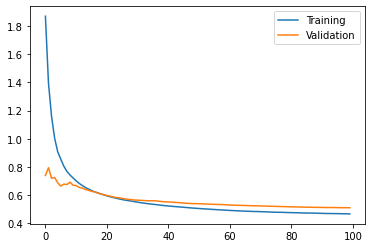

In [49]:
classifier = train(100, DNN(200))

In [50]:
def test_model(dataloader):
    classifier.eval()
    
    prediction = []
    real = []
    
    for batch, (x,y) in enumerate(dataloader, 0):
        prediction.append(classifier(x).item())
        real.append(y.item())
    dataframe = pd.DataFrame([np.array(real).reshape(-1,),
                              np.array(prediction).reshape(-1,)])
    
    return dataframe.T

In [51]:
prediction = test_model(test_loader)
prediction

,0,1
0,5.0,5.294981
1,5.0,5.162532
2,7.0,5.727668
3,7.0,5.985777
4,6.0,5.931182
...,...,...
315,6.0,6.232430
316,5.0,5.162532
317,6.0,5.702014
318,6.0,5.627409


In [62]:
explain = GradientExplainer(classifier, train_x)

In [66]:
explain